# Appendix A.1 - Data Collection

In [1]:
from pydaqmx_helper.adc import ADC
from pydaqmx_helper.digital_io import Digital_IO
import time

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
adc = ADC()

In [4]:
adc.addChannels([1])
print(adc.getActiveChannels())

Activated Channel 1
[1]


In [6]:
dio = Digital_IO('0', 'output')

Created digital output port: Dev2/port0


In [23]:
def SetState(state, dio=dio):
    dio.write(state)


def Turn(enabled, N=1, prism=False, detector=False, direction="cw", doubleDetector=False, delay=0.1,\
         reverse=False, stationary=False):
    
    direction = direction.lower()
    voltages = []*N
    uncertainties = []*N
    itterations = []*N
    
    # Enable
    if not stationary:
        if enabled:
            currentState = 1
            SetState(currentState)
        else:
            currentState = 1
            SetState(0)
            return
    elif stationary:
        currentState = 0
        SetState(currentState)
        
    # Selecting Direction
    if (direction == "ccw"):
        currentState += 2
        SetState(currentState)
        
    elif (direction == "cw"):
        SetState(currentState)
    
    else:
        currentState = 0
        SetState(currentState)
        print("Motor Disabled, invalid input")
        return
    
    print("Starting Cycle...")
    # Do turn cycle
    # Delay 100 ms
    time.sleep(0.1)
    
    for i in range(N):
        print(f"Cycle {i}/{N}", end="\r")
              
        if detector:
            # Turn motor two
            currentState += 16
            SetState(currentState)
            currentState -= 16
            SetState(currentState)
            
            time.sleep(delay)
            
            if doubleDetector:
                currentState += 16
                SetState(currentState)
                currentState -= 16
                SetState(currentState)
                time.sleep(delay)
                
            if prism:
                # Turn motor one
                currentState += 8
                SetState(currentState)
                currentState -= 8
                SetState(currentState)
        
        if prism and not detector:
            # Turn motor one
            currentState += 8
            SetState(currentState)
            currentState -= 8
            SetState(currentState)

            time.sleep(delay)
        
        time.sleep(delay)
        
        itterations.append(i)
        V=adc.sampleVoltages(100, 10000)[1] # 100 samples at 10000 Hz
        voltages.append(np.mean(V))
        uncertainties.append(np.std(V))
        
        if stationary:
            time.sleep(1)
        
    
    print("Cycle Complete, disabling motors")
    currentState = 0
    SetState(currentState)
    
    if reverse:
        reverseItterations = itterations[::-1]
        return [reverseItterations, voltages, uncertainties]
    
    return [itterations, voltages, uncertainties]

In [59]:
Turn(False)

In [19]:
Turn(True, 10, prism=True, detector=False, direction="cw", doubleDetector=True);

Starting Cycle...
Cycle Complete, disabling motors


In [9]:
# Calibrate turns to degrees function
# From calibration, the system moves 45 degrees in 1000 turns for both the prism and the detector

def DegToTurns(deg):
    ratio = 45/1000 # degrees / turns
    return deg / ratio

def TurnsToDeg(turns):
    ratio = 45/1000 # degrees / turns
    return turns * ratio

In [10]:
DegToTurns(65)

1444.4444444444446

In [42]:
print(f"Red and Green Offset: {TurnsToDeg(670)}")
print(f"Blue Offset: {TurnsToDeg(970)}")

Red and Green Offset: 30.15
Blue Offset: 43.65


In [11]:
def WriteFile(fileName, data):
 
    data = np.transpose(data)
    
    with open(fileName, "w") as f:
        np.savetxt(fileName, data)

In [12]:
def LoadFile(path):
    data = np.array(np.loadtxt(path))
    return data

In [47]:
def PlotFile(path):
    data = LoadFile(path)
        
    plt.xlabel("N")
    plt.ylabel("Intensity")
    plt.grid()
    plt.plot(data[:,0], data[:,1])

# Data Acquisition

In [1]:
# Note that we assume detector needs to move twice as much as the prism

# 0 deg is defined at perfect reflection, this is read at an angle of 130 deg
# Starting with the prism at 120

### Example data acquisition

In [80]:
WriteFile("15nm/red/red01.txt", Turn(True, 600, prism=True, detector=True, direction="cw", doubleDetector=True))

Starting Cycle...
Cycle Complete, disabling motors


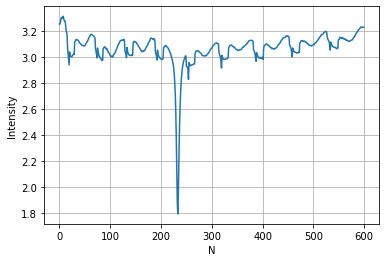

In [81]:
PlotFile("15nm/red/red01.txt")